In [1]:
!butler query-datasets /repo/embargo --collections LSSTComCam/raw/all --where "instrument='LSSTComCam' AND day_obs=20240806 AND exposure=2024080600138"

lsst.daf.butler.script.queryDatasets INFO: Filtered 3574 dataset types down to 1

type        run                          id                  instrument detector    exposure   band day_obs          group          physical_filter
---- ------------------ ------------------------------------ ---------- -------- ------------- ---- -------- ---------------------- ---------------
 raw LSSTComCam/raw/all 38b7e0dd-e199-55e7-a88c-c25a4245cdcd LSSTComCam        0 2024080600138    g 20240806 BT68_O_20240806_000004            g_01
 raw LSSTComCam/raw/all 50e4eecf-990c-560f-a62c-45889ab62194 LSSTComCam        1 2024080600138    g 20240806 BT68_O_20240806_000004            g_01
 raw LSSTComCam/raw/all 5cc766db-880d-557a-b56a-0400aa5f2709 LSSTComCam        2 2024080600138    g 20240806 BT68_O_20240806_000004            g_01
 raw LSSTComCam/raw/all fae8919f-28dc-55fd-9301-d785f54f6d7c LSSTComCam        3 2024080600138    g 20240806 BT68_O_20240806_000004            g_01
 raw LSSTComCam/raw/all 2e98bd

In [71]:
import lsst.daf.butler as butler
from lsst.ip.isr import IsrTask
from lsst.ip.isr import IsrTaskConfig
from lsst.afw.math import makeStatistics
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.base import PipelineTask
import json
import numpy as np
import multiprocessing
import logging

In [72]:
import lsst.daf.butler as daf_butler
import concurrent.futures
import json
import logging
from itertools import islice

# Lower the logging level for LSST translators to suppress warnings
logging.getLogger('lsst.obs.lsst.translators.comCam').setLevel(logging.ERROR)

repo_path = '/repo/embargo'
collection = 'LSSTComCam/raw/all'

# Function to create a Butler instance
def create_butler(repo_path):
    return daf_butler.Butler(repo_path)

# Function to convert dataId to a JSON-serializable format using toSimple()
def serialize_data_id(data_id):
    # Use toSimple() to convert the _FullTupleDataCoordinate into a dictionary
    return data_id.to_json()

# Function to write data to file immediately
def write_to_file(data_ref):
    # Serialize the data_ref.dataId using toSimple() to ensure it is JSON-serializable
    serializable_data_id = serialize_data_id(data_ref.dataId)
    # print(f"Writing data to file: {serializable_data_id}")  # Debugging print
    with open('outputfile.json', 'a') as fout:
        json.dump(serializable_data_id, fout)  # Dump the serialized data_id to file
        fout.write('\n')  # Ensure newline after each entry for readability
        fout.flush()  # Flush to ensure data is written immediately

# Function to process each data reference with worker-specific Butler access
def process_with_butler(data_ref):
    try:
        butler = create_butler(repo_path)  # Each process will get its own Butler instance
        header = butler.get('raw.metadata', collections=collection, dataId=data_ref.dataId)
        img_type = header.get('IMGTYPE')
        if img_type == "DARK":
            write_to_file(data_ref)
        return data_ref, img_type
    except Exception as e:
        print(f"Error retrieving metadata for {data_ref.dataId}: {e}")
        return data_ref, None

# Query for raw datasets
def query_data_refs():
    butler = daf_butler.Butler(repo_path)
    data_refs = list(butler.registry.queryDatasets(
        datasetType="raw", collections=collection, where="instrument='LSSTComCam'"))
    return data_refs

# Batch the dataset to reduce memory usage
def batched(iterable, n):
    """Batch data into chunks of size n."""
    iterator = iter(iterable)
    for first in iterator:
        yield list(islice(iterator, n - 1))

# Main function for parallel processing with memory optimizations and progress tracking
def process_darks(batch_size=100, max_workers=2):
    data_refs = query_data_refs()
    total = len(data_refs)
    completed = 0

    # Clear file content at the beginning
    open('outputfile.json', 'w').close()

    # Process data in batches
    for batch in batched(data_refs, batch_size):
        with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
            futures = {executor.submit(process_with_butler, data_ref): data_ref for data_ref in batch}

            for future in concurrent.futures.as_completed(futures):
                data_ref, img_type = future.result()

                # Update and print progress
                completed += 1
                print(f"\rProgress: {completed}/{total} completed ({(completed / total) * 100:.2f}%)", end="")

def read_json_file(file_path):
    data_list = []
    
    with open(file_path, 'r') as f:
        for line in f:
            try:
                # Load each line as a dictionary and append to the list
                data = json.loads(json.loads(line.strip()))
                data_list.append(data)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
    
    return data_list

In [ ]:
process_darks(batch_size=1000, max_workers=4)

Progress: 71532/119462 completed (59.88%)

In [53]:
data_refs=read_json_file("outputfile.json")

In [58]:
# Retrieve a single raw exposure and inspect its header
repo_path = '/repo/embargo'
collection = 'LSSTComCam/raw/all'
butler = daf_butler.Butler(repo_path)
data_refs = read_json_file("outputfile.json")
data_ref = data_refs[1]  # Get the first dataset reference
raw = butler.get('raw', collections=collection, dataId=data_ref["dataId"])

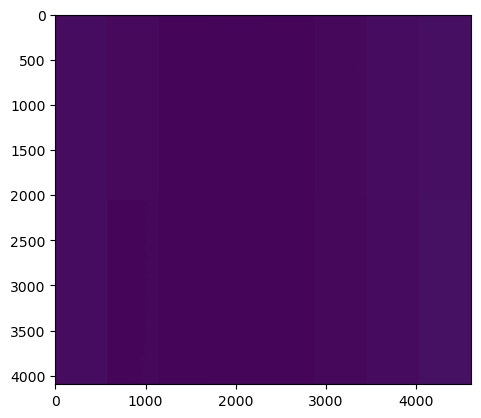

In [70]:
import matplotlib.pyplot as plt
plt.imshow(raw.image.array)

In [66]:
raw.image.array.max()

120410.0

In [29]:
# Retrieve a single raw exposure and inspect its header
repo_path = '/repo/embargo'
collection = 'LSSTComCam/raw/all'
butler = daf_butler.Butler(repo_path)
data_refs = list(butler.registry.queryDatasets(datasetType="raw", collections=collection, where="instrument='LSSTComCam'"))
data_ref = list(data_refs)[1029]  # Get the first dataset reference
header = butler.get('raw.metadata', collections=collection, dataId=data_ref.dataId)
print(header.get('IMGTYPE'))


BIAS


In [33]:
import lsst.daf.butler as daf_butler
import json

# Initialize the Butler (you will need this to work with the data)
repo_path = '/repo/embargo'
butler = daf_butler.Butler(repo_path)

# Function to reconstruct a _FullTupleDataCoordinate from a serialized dictionary
def reconstruct_data_id(serialized_data):
    """Reconstruct a _FullTupleDataCoordinate from a serialized dictionary."""
    # Use Butler's DataCoordinate system to reconstruct the object
    return butler.registry.expandDataId(serialized_data)

# Function to read from the output JSON file and reconstruct the list of _FullTupleDataCoordinate objects
def read_and_reconstruct(file_path):
    full_tuple_list = []

    # Open and read the JSON file
    with open(file_path, 'r') as file:
        for line in file:
            serialized_data = json.loads(line)
            # Reconstruct the _FullTupleDataCoordinate from the serialized data
            full_tuple_data_id = reconstruct_data_id(serialized_data)
            full_tuple_list.append(full_tuple_data_id)

    return full_tuple_list

# Path to the JSON file that was written earlier
file_path = 'outputfile.json'

# Read and reconstruct the data
reconstructed_data_ids = read_and_reconstruct(file_path)

# Verify the output (optional print for testing)
for data_id in reconstructed_data_ids:
    print(data_id)


ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [32]:
type(data_ref.dataId)

lsst.daf.butler.dimensions._coordinate._FullTupleDataCoordinate

In [19]:
data_ref.dataId.to_json()

'{"dataId":{"instrument":"LSSTComCam","detector":5,"exposure":2022111600060,"band":"i","day_obs":20221116,"group":"2022-11-16T19:58:36.713","physical_filter":"i_06"}}'

In [18]:
dir(data_ref.dataId)

['__annotations__',
 '__bool__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_dimensions',
 '_record',
 '_serializedType',
 '_values',
 'dimensions',
 'expanded',
 'from_full_values',
 'from_json',
 'from_required_values',
 'from_simple',
 'full_values',
 'get',
 'hasFull',
 'hasRecords',
 'makeEmpty',
 'make_empty',
 'mapping',
 'records',
 'region',
 'required',
 'required_values',
 'standardize',
 'subset',
 'timespan',
 'to_json',
 'to_simple',
 'union',
 'universe']